In [56]:
# ok now first lets turn the last part model from computer vision to use a functional training and testing loop

import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [57]:
torch.cuda.is_available()

True

In [58]:
class FashionModelV3 (nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0= nn.Flatten()
        self.layer1= nn.Linear(in_features=784, out_features=256)
        self.layer2= nn.Linear(in_features=256, out_features=10)
        self.relu= nn.ReLU()
        
    def forward(self, x:torch.Tensor)-> torch.Tensor:
        result= self.layer0(x)
        result= self.layer1(result)
        result= self.relu(result)
        result= self.layer2(result)
        return result

Now is the time to create functional training and testing loop
# First lets define the parameters they are going to take
So naturaly they would take the model, data(data loader), loss function , optimizer function, epoch, device

In [59]:
from typing import Callable
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_model(model:nn.Module,
                data:torch.utils.data.DataLoader,
                lossFn: nn.Module, 
                optimizer:torch.optim.Optimizer,
                epochs:int,
                accr_fun: Callable[[torch.Tensor, torch.Tensor], float],
                device:torch.device):
    model.to(device)

    batch_avg_accuracy=[]
    loss_per_epoch= []
    clock_start= timer()
    # Now a new info i got is the avg_ccr is not always exactly the same as true accuracy and only works when batch 
    # size is equal for all of them, to test this we will add another accuracy
    dataset_accuracy= []
    for epoch in tqdm(range(epochs)):
        total_correct =0
        total_samples= 0
        true_accuracy= 0
        avg_loss= 0
        avg_acc_batch=0
        model.train()
        for X , y in data:
            X= X.to(device)
            y= y.to(device)
            logit= model(X)
            preds= torch.argmax(logit, dim=1)
            
            
            loss= lossFn(logit, y)

            avg_acc_batch += accr_fun(y, preds)
            avg_loss += loss.item()
            total_correct += (preds == y).sum().item()
            total_samples += len(y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            
        avg_loss /= len(data)
        avg_acc_batch /= len(data)
        batch_avg_accuracy.append(avg_acc_batch)
        loss_per_epoch.append(avg_loss)
        true_accuracy= total_correct / total_samples
        dataset_accuracy.append(true_accuracy)
    
    clock_stop= timer()
    time_taken= clock_stop - clock_start
        
    return {
        'batch_avg_accuracy': batch_avg_accuracy,
        'loss_per_epoch': loss_per_epoch,
        'time_taken' : time_taken,
        'dataset_accuracy': dataset_accuracy
    }
            
            

In [60]:
# Now lets define the accuracy function we mentioned as a parameter for the training loop
def accuracy_function(correct:torch.Tensor, prediction: torch.Tensor)-> float:
    rslt= (correct == prediction).sum().item()
    size= len(correct)
    return rslt/size
    

In [61]:
def test_model(model:nn.Module,
               data:torch.utils.data.DataLoader,
               lossFn: nn.Module,
               device:torch.device):
    model.to(device)
    model.eval()
    total_correct= 0
    total_samples= 0
    total_loss=0
    with torch.inference_mode():
        for X , y in data:
            X= X.to(device)
            y= y.to(device)
            logits= model(X)
            pred= torch.argmax(logits, dim=1)
            total_correct += (y == pred).sum().item()
            total_samples += len(y)
            
            loss= lossFn(logits, y)
            total_loss += loss.item()
            
    accuracy= total_correct / total_samples
    loss= total_loss / len(data)
    return {
        'accuracy': accuracy,
        'loss': loss
    }
    
            
            

In [62]:
train_dataset= datasets.FashionMNIST(
    root='data',
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform= None
)

test_dataset= datasets.FashionMNIST(
    root= 'data',
    train= False,
    download=True,
    transform= ToTensor()
)

In [63]:
len(train_dataset), len(test_dataset)


(60000, 10000)

In [64]:
img, label= train_dataset[0]
img.shape , label


(torch.Size([1, 28, 28]), 9)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

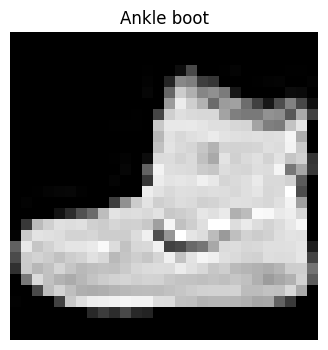

In [65]:
img= img.squeeze()
plt.figure(figsize=(4,4))
plt.imshow( img,cmap='gray')
plt.title(train_dataset.classes[label])
plt.axis(False)

In [66]:
from torch.utils.data import DataLoader

BATCH_SIZE=32
train_data_batched= DataLoader(
    train_dataset,
    BATCH_SIZE,
    shuffle=True
    )
test_data_batched= DataLoader(
    test_dataset,
    BATCH_SIZE,
    shuffle=False
)

model_fsh= FashionModelV3()
loss_fn= nn.CrossEntropyLoss()
optimzr= torch.optim.Adam(params=model_fsh.parameters(), lr=0.002)
EPOCHS= 5
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_result= train_model(model_fsh, train_data_batched, loss_fn, optimzr, EPOCHS, accuracy_function, device)
print(train_result)
print("-----------------------------------------------------------")
test_result= test_model(model_fsh, test_data_batched,loss_fn, device)
print(test_result)


  0%|          | 0/5 [00:00<?, ?it/s]

{'batch_avg_accuracy': [0.8278, 0.8656833333333334, 0.8774333333333333, 0.8854166666666666, 0.8912833333333333], 'loss_per_epoch': [0.47777769082784655, 0.3663988682190577, 0.3315287455221017, 0.31042813672026, 0.29554639617800715], 'time_taken': 47.1048031119999, 'dataset_accuracy': [0.8278, 0.8656833333333334, 0.8774333333333333, 0.8854166666666666, 0.8912833333333333]}
-----------------------------------------------------------
{'accuracy': 0.8765, 'loss': 0.34171678337711875}
